In [ ]:
##########################################
##### Install the relevant packages #####
##########################################
#This will take several minutes

if (!requireNamespace("BiocManager", quietly = TRUE)) #Install bioconductor, repository of bioinformatics packages in R
    install.packages("BiocManager")

BiocManager::install("edgeR"); #Install the EdgeR package

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.rstudio.com


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.1 (2021-08-10)

Installing package(s) 'BiocVersion', 'edgeR'

also installing the dependencies ‘limma’, ‘locfit’


Old packages: 'pbdZMQ', 'backports', 'broom', 'cli', 'crayon', 'generics',
  'openssl', 'sessioninfo', 'tzdb', 'usethis', 'uuid', 'nlme'



In [ ]:
install.packages("gplots");
install.packages("gplots2");

##########################################
##### Load the libraries #####
##########################################
library(edgeR);
library(gplots);
library(ggplot2);

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘gplots2’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Loading required package: limma


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [ ]:
##########################################
##### Read in the relevant datasets #####
##########################################
#Read in the peak predictions for motor cortex open chromatin

##### Download the matrix of predicted peaks #####

peakUrl <- "https://www.andrew.cmu.edu/user/apfennin/2021_Fall_GEB/project/Corces2020.MSN_D1.calibPeaks.avgCNN.predictions.txt.gz";
system(paste("wget ",peakUrl));



In [ ]:
peakPredM <- as.matrix(read.table(file = gzfile("Corces2020.MSN_D1.calibPeaks.avgCNN.predictions.txt.gz"), stringsAsFactors = F, header=T));

peaksM <- as.matrix(peakPredM[,c("Microcebus_murinus","Propithecus_coquereli","Eulemur_flavifrons","Homo_sapiens","Piliocolobus_tephrosceles","Nomascus_leucogenys")]);
rownames(peaksM) <- peakPredM[,c("name")];
peaksM[1:5,]

,Microcebus_murinus,Propithecus_coquereli,Eulemur_flavifrons,Homo_sapiens,Piliocolobus_tephrosceles,Nomascus_leucogenys
hg38:chr22:21825556-21826056:250,5.841272e-01,5.674196e-01,6.443164e-01,5.362953e-01,3.320594e-01,4.437481e-01
hg38:chr8:41731592-41732092:250,NA,8.202694e-01,3.152307e-01,4.423054e-01,3.026091e-01,NA
hg38:chr8:41767708-41768208:250,2.517374e-01,2.815401e-01,2.005022e-01,2.817274e-01,2.280802e-01,3.318722e-01
hg38:chr8:41822712-41823212:250,NA,7.771182e-02,2.048966e-01,6.822142e-01,5.966056e-01,2.425521e-01
hg38:chr8:41834624-41835124:250,2.688745e-01,1.775279e-01,6.575107e-02,2.278489e-01,2.251176e-01,1.620428e-01


In [ ]:
# Record trait annotation in HashMap
install.packages('hash')
library(hash)
traitAnnotH = hash()
traitAnnotH[["Microcebus_murinus"]] <- 5;
traitAnnotH[["Propithecus_coquereli"]] <- 9.15;
traitAnnotH[["Eulemur_flavifrons"]] <- 1;
traitAnnotH[["Homo_sapiens"]] <- 5.75;
traitAnnotH[["Piliocolobus_tephrosceles"]] <- 4;
traitAnnotH[["Nomascus_leucogenys"]] <- 8.55

# put this in a data frame
traitAnnotF = data.frame(species = colnames(peaksM))
traitAnnotV = c()
for (species in traitAnnotF$species){
  traitAnnotV = append(traitAnnotV, traitAnnotH[[species]])
}
traitAnnotF$traitAnnot = traitAnnotV
traitAnnotF

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

hash-2.2.6.1 provided by Decision Patterns




species,traitAnnot
<chr>,<dbl>
Microcebus_murinus,5.00
Propithecus_coquereli,9.15
Eulemur_flavifrons,1.00
Homo_sapiens,5.75
Piliocolobus_tephrosceles,4.00
Nomascus_leucogenys,8.55


In [ ]:
# ####### Read in the distance matrix based on the whole genome sequence alignment ############
# #Low values mean the species are more similar to each other
# molecularSimM <- as.matrix(read.csv(file="http://www.andrew.cmu.edu/user/apfennin/2021_Fall_GEB/hw2/200Mammal_hal_tree_noancestors_matrix.csv",stringsAsFactors=F,header=T,row.names=1));

In [ ]:
# ### Adjust the molecular similarity matrix to be symmetric ###
# molecularDistM <- 1 - molecularSimM;
# for(curSpec1 in rownames(molecularDistM)) {
#   for(curSpec2 in colnames(molecularDistM)) {
#     if(curSpec1 != curSpec2) {
#       if(is.na(molecularDistM[curSpec1,curSpec2])) {
#         molecularDistM[curSpec1,curSpec2] = molecularDistM[curSpec2,curSpec1]
#       }
#     } else {
#       molecularDistM[curSpec1,curSpec2] = 0;
#     }
#   }
# }
# molecularDistM <- as.matrix(molecularDistM[c("Microcebus_murinus","Propithecus_coquereli","Eulemur_flavifrons","Homo_sapiens","Piliocolobus_tephrosceles","Nomascus_leucogenys"),
# c("Microcebus_murinus","Propithecus_coquereli","Eulemur_flavifrons","Homo_sapiens","Piliocolobus_tephrosceles","Nomascus_leucogenys")]);


# molecularDistM

In [ ]:
# ### T-test --> pval ###
# foregroundSpeciesV <- c("Microcebus_murinus", "Eulemur_flavifrons", "Piliocolobus_tephrosceles")
# backgroundSpeciesV <- c("Propithecus_coquereli", "Homo_sapiens", "Nomascus_leucogenys")


# diffPvaluesV <- rep(NA,length(peaksM[,"Microcebus_murinus"])); 
# names(diffPvaluesV) <- row.names(peaksM); 
# diffMeansV <- diffPvaluesV 

# for(curPeak in row.names(peaksM)) { 
#   curForegroundValuesV <- as.double(peaksM[curPeak,foregroundSpeciesV]);
#   curBackgroundValuesV <- as.double(peaksM[curPeak,backgroundSpeciesV]); 
#   if(length(which(!is.na(curForegroundValuesV))) > 1 && length(which(!is.na(curBackgroundValuesV))) > 1) { 
#     if(sd(curForegroundValuesV,na.rm=T) > 0 && sd(curBackgroundValuesV,na.rm=T) > 0) { 
#       curTtest <- t.test(x=curForegroundValuesV,y=curBackgroundValuesV); 
#       diffPvaluesV[curPeak] <- curTtest$p.value
#       diffMeansV[curPeak] <- mean(as.double(peaksM[curPeak,foregroundSpeciesV]),na.rm=T) - mean(as.double(peaksM[curPeak,backgroundSpeciesV]),na.rm=T);
#     }
#   }

# }

**For each cell type, for each region of open chromatin, calculate the difference in open chromatin between/across the species of choice.**
1. First, you need to calculate a significance value (p-value) that describes the extent to which each region is associated with the trait annotation.
2. Second, calculate a value that represents the magnitude and direction of the difference. This includes whether the open chromatin is predicted to be higher or lower when your trait varies. It also includes the extent to which it is different. This can be a difference in means across groups or the correlation between the trait and predicted open chromatin.

We used a correlation value between the trait and the predicted open chromatin. Specifically, it is the slope of the fitted linear regression line.

3. For each of those two measures (p-value and magnitude/direction) plot a histogram of the distribution of values. What do those histograms tell you about the statistical tests you conduct?

There are fewer significant p values than we expect by random chance. This means that there probably is a lot of noise in the data. There are slightly more genes that have expression levels that are positively correlated with social group size and those with expression levels that are negatively correlated with social group size because the middle of the slope histogram is shifted slightly to the right from 0.

4. Perform a p-value correction for multiple hypotheses. How many regions are significantly positively or significantly negatively associated at an adjusted p-value of <= 0.1? (It’s OK if there are none, sometimes we are statistically under-powered).

None.

In [ ]:
### Linear regression ---> pval ###
diffPvaluesV<- rep(NA,length(peaksM[,"Microcebus_murinus"]));
names(diffPvaluesV) <- row.names(peaksM); 
diffSlopeV <- diffPvaluesV

for(curPeak in row.names(peaksM)){
  curRow = as.double(peaksM[curPeak,])
  if(length(which(!is.na(curRow))) > 4 && sd(curRow,na.rm=T) > 0) {
    newDfForPeak = data.frame(species = colnames(peaksM), POCValue = curRow, traitAnnot = traitAnnotF["traitAnnot"])
    lmpeak = lm(traitAnnot~POCValue, data = newDfForPeak)
    diffPvaluesV[curPeak] = summary(lmpeak)$coefficients["POCValue", "Pr(>|t|)"]
    diffSlopeV[curPeak] = summary(lmpeak)$coefficients["POCValue", "Estimate"]
  }
}

In [ ]:
diffPvaluesV[1:10]
diffSlopeV[1:10]

hg38:chr22:21825556-21826056:250  hg38:chr8:41731592-41732092:250 
                      0.68254953                               NA 
 hg38:chr8:41767708-41768208:250  hg38:chr8:41822712-41823212:250 
                      0.01667111                       0.65635646 
 hg38:chr8:41834624-41835124:250  hg38:chr8:42005314-42005814:250 
                      0.53121696                       0.22100222 
 hg38:chr8:42015612-42016112:250  hg38:chr8:42017819-42018319:250 
                              NA                       0.75337150 
 hg38:chr8:42423772-42424272:250  hg38:chr8:42673983-42674483:250 
                              NA                               NA

hg38:chr22:21825556-21826056:250  hg38:chr8:41731592-41732092:250 
                       -5.761515                               NA 
 hg38:chr8:41767708-41768208:250  hg38:chr8:41822712-41823212:250 
                       58.177274                        -3.482073 
 hg38:chr8:41834624-41835124:250  hg38:chr8:42005314-42005814:250 
                       13.736728                       -77.354403 
 hg38:chr8:42015612-42016112:250  hg38:chr8:42017819-42018319:250 
                              NA                         3.126385 
 hg38:chr8:42423772-42424272:250  hg38:chr8:42673983-42674483:250 
                              NA                               NA

In [ ]:
diffResultsF <- data.frame(id=row.names(peaksM), slope=diffSlopeV, pvalue=diffPvaluesV, padj = p.adjust(diffPvaluesV))
diffResultsSortPadjF <- diffResultsF[order(diffResultsF$padj),]
diffResultsSortPvalueF <- diffResultsF[order(diffResultsF$pvalue),]
diffResultsSortPadjF[1:5,]
diffResultsSortPvalueF[1:5,]

,id,slope,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>
hg38:chr22:21825556-21826056:250,hg38:chr22:21825556-21826056:250,-5.761515,0.68254953,1
hg38:chr8:41767708-41768208:250,hg38:chr8:41767708-41768208:250,58.177274,0.01667111,1
hg38:chr8:41822712-41823212:250,hg38:chr8:41822712-41823212:250,-3.482073,0.65635646,1
hg38:chr8:41834624-41835124:250,hg38:chr8:41834624-41835124:250,13.736728,0.53121696,1
hg38:chr8:42005314-42005814:250,hg38:chr8:42005314-42005814:250,-77.354403,0.22100222,1


,id,slope,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>
hg38:chr3:1353150-1353650:250,hg38:chr3:1353150-1353650:250,12.58979,8.864455e-05,1
hg38:chr18:37538346-37538846:250,hg38:chr18:37538346-37538846:250,21.94954,2.080967e-04,1
hg38:chr4:81922206-81922706:250,hg38:chr4:81922206-81922706:250,23.07976,2.389770e-04,1
hg38:chr5:167694170-167694670:250,hg38:chr5:167694170-167694670:250,15.33658,4.385547e-04,1
hg38:chr5:178076066-178076566:250,hg38:chr5:178076066-178076566:250,54.89946,6.620295e-04,1


In [ ]:
diffResultsSortPvalueF[1:10,]

,id,slope,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>
hg38:chr3:1353150-1353650:250,hg38:chr3:1353150-1353650:250,12.58979,8.864455e-05,1
hg38:chr18:37538346-37538846:250,hg38:chr18:37538346-37538846:250,21.94954,2.080967e-04,1
hg38:chr4:81922206-81922706:250,hg38:chr4:81922206-81922706:250,23.07976,2.389770e-04,1
hg38:chr5:167694170-167694670:250,hg38:chr5:167694170-167694670:250,15.33658,4.385547e-04,1
hg38:chr5:178076066-178076566:250,hg38:chr5:178076066-178076566:250,54.89946,6.620295e-04,1
hg38:chr7:104538106-104538606:250,hg38:chr7:104538106-104538606:250,-23.69429,7.502267e-04,1
hg38:chr7:151759441-151759941:250,hg38:chr7:151759441-151759941:250,-17.09407,8.756438e-04,1
hg38:chr2:122516831-122517331:250,hg38:chr2:122516831-122517331:250,30.08444,9.634151e-04,1
hg38:chr13:111385333-111385833:250,hg38:chr13:111385333-111385833:250,42.12960,1.036529e-03,1


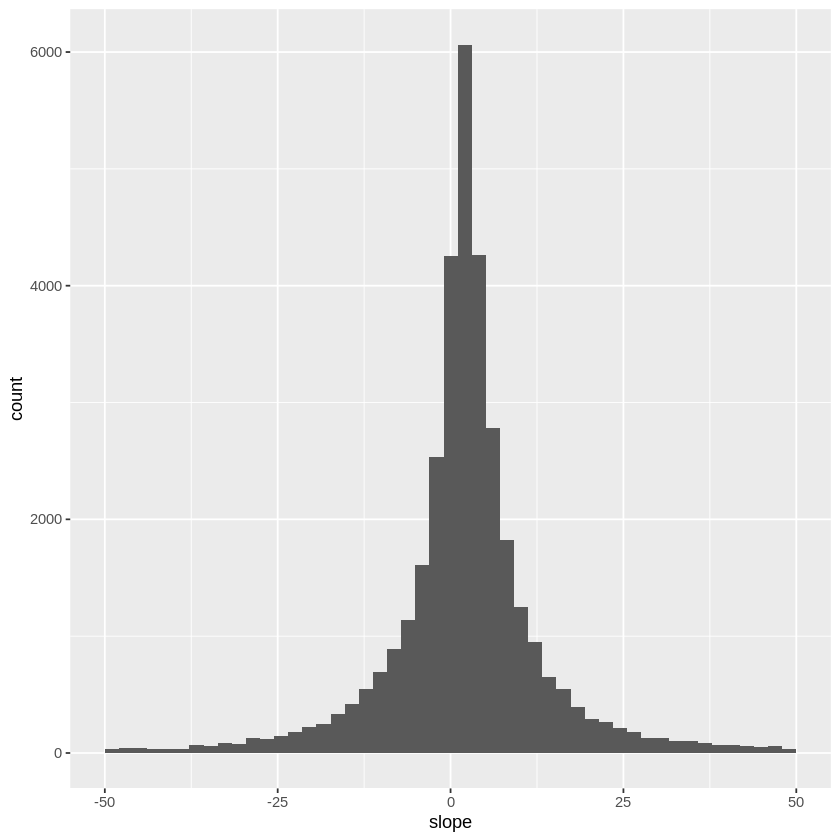

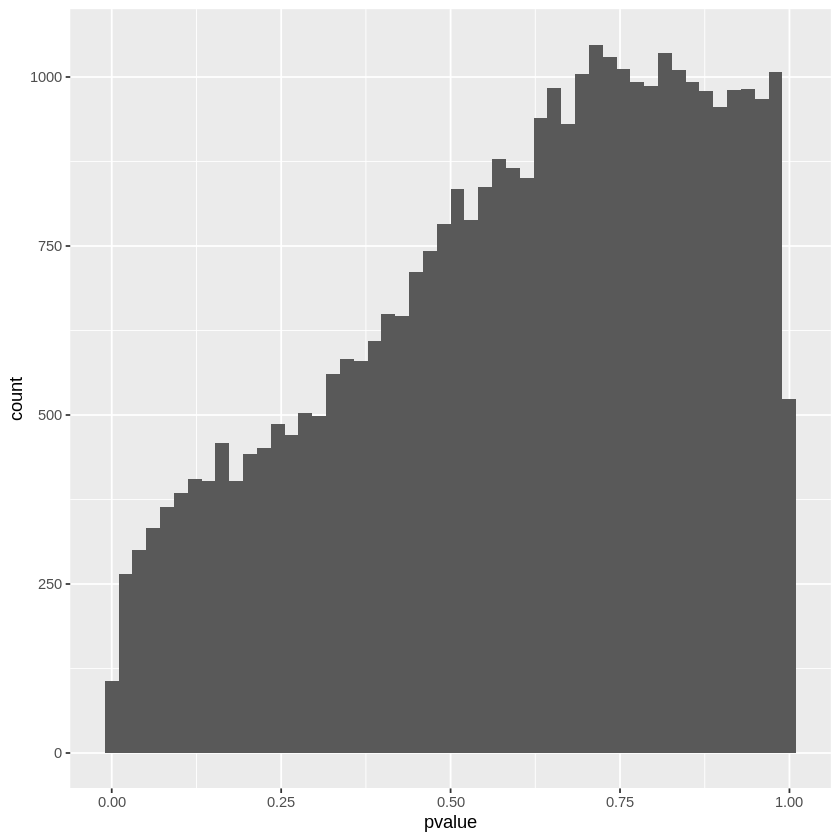

In [ ]:
ggplot(diffResultsF, aes(slope)) + geom_histogram(na.rm = TRUE, bins = 50) + xlim(-50, 50)
ggplot(diffResultsF, aes(pvalue)) + geom_histogram(na.rm = TRUE, bins = 50)

**For each cell type, find the peak that is most positively and most negatively associated with the trait (based on un-adjusted p-value).**

1. Create a barplot or scatter plot for those peak that show its association with the trait.

2. Visualize those peaks in the UCSC browser to find the some of the nearby genes. For each of those peaks, perform a literature search using pubmed for one of the nearby genes. What is the function of that gene and does it relate at all to the trait you are studying?

a. The peak that is most positively associated with the trait is located within one intron of CNTN6. Deletions and coding sequence variants in CNTN6 are enriched in individuals with autism spectrum disorders (ASD) compared to non-autistic controls (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5378808/). CNTN6 encodes a neural cell adhesion protein that promotes neurite outgrowth and synapse formation, and it is especially important for sensory-motor pathway development in mice (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5378808/). Because ASD is characterized by impaired social behaviors, expression level of CNTN6 can play a role in regulating social behaviors, and hence social group size.

b. The peak that is most negatively associated with the trait is located within an intron of LHFPL3, which can also be referred to as LHFPL4 (https://www.ncbi.nlm.nih.gov/gene?Db=gene&Cmd=DetailsSearch&Term=375612). LHFPL4 is found to be essential for binding to post-synaptic GABA A receptors and anchoring them to the post-synaptic membrane, forming to reliable inhibitory synapses (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5640807/). There has been conflicting reports of the effects of LHFPL4 knockout on behaviors. Davenport et al. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5640807/) reported no behavioral changes in LHFPL4-/- mice, whereas Wu et al. (https://www.sciencedirect.com/science/article/pii/S2211124718305448) reported that complete knockout of LHFPL4 led to premature death, and imcomplete knockout of it led to deficits in motor behaviors in mice. Futher assessment of the behavioral consequences of LHFPL4 knockout and potential roles of LHFPL4 in producing animal behaviors, especially social behaviors, is needed. However, based on the function of LHFPL4, we can speculate its impact on social behaviors. Blocking GABA A receptor can lead to impaired sociability in rodents (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6948928/). Therefore, LHFPL4 expression level could be related to social behaviors as well.


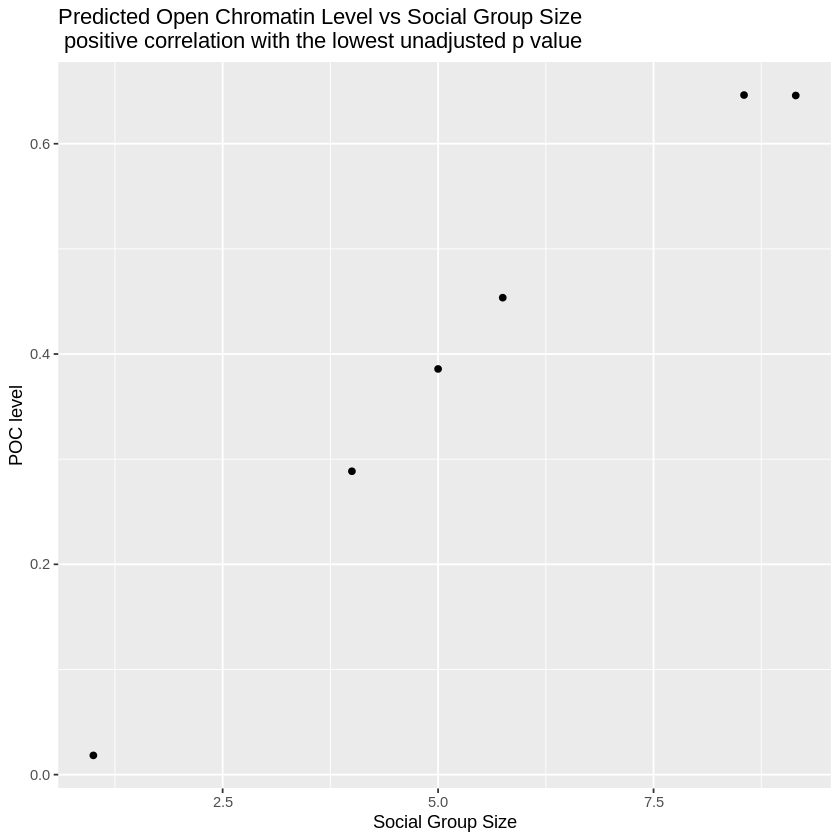

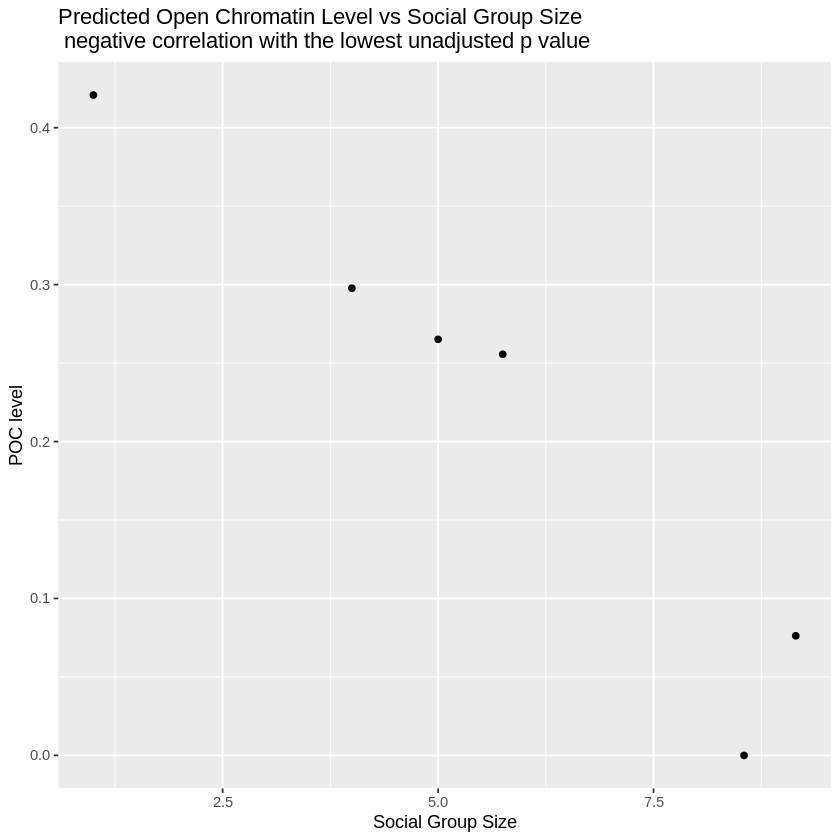

In [ ]:
# mostPosPeak = "hg38:chr1:99332362-99332862:250"
# mostNegPeak = "hg38:chr12:55064820-55065320:250"
# mostPosPeak = "hg38:chr3:1353150-1353650:250"
# mostNegPeak = "hg38:chr10:60611353-60611853:250"
mostPosPeak = "hg38:chr3:1353150-1353650:250"
mostNegPeak = "hg38:chr7:104538106-104538606:250"


 # set na to 0
mostPosAndNegPeaksF <- data.frame(PosPeak = as.double(peaksM[which(row.names(peaksM) == mostPosPeak),]),
                    NegPeak = as.double(peaksM[which(row.names(peaksM) == mostNegPeak),]))
mostPosAndNegPeaksF[is.na(mostPosAndNegPeaksF)] = 0
mostPosAndNegPeaksF$species = colnames(peaksM)
mostPosAndNegPeaksF <- merge(mostPosAndNegPeaksF,traitAnnotF,by="species")

# mostPosAndNegPeaksF$foreground <- rep("background",length(mostPosAndNegPeaksF[,"species"])); 
# mostPosAndNegPeaksF$foreground[is.element(mostPosAndNegPeaksF$species, foregroundSpeciesV)] = "foreground";
# mostPosAndNegPeaksF
# ggplot(data = mostPosAndNegPeaksF, aes(x = species, y = PosPeak, fill = foreground)) + geom_bar(stat="identity") + theme(axis.text.x = element_text(angle = 45, hjust = 1))
# ggplot(data= mostPosAndNegPeaksF, aes(x = species, y = NegPeak, fill = foreground)) + geom_bar(stat="identity") +theme(axis.text.x = element_text(angle = 45, hjust = 1))
# ggplot(data = mostPosAndNegPeaksF, aes(x = species, y = PosPeak)) + geom_bar(stat="identity") + theme(axis.text.x = element_text(angle = 45, hjust = 1))
# ggplot(data= mostPosAndNegPeaksF, aes(x = species, y = NegPeak)) + geom_bar(stat="identity") +theme(axis.text.x = element_text(angle = 45, hjust = 1))
ggplot(data = mostPosAndNegPeaksF, aes(x = traitAnnot, y = PosPeak)) + geom_point() + ggtitle("Predicted Open Chromatin Level vs Social Group Size \n positive correlation with the lowest unadjusted p value") +
  xlab("Social Group Size") + ylab("POC level")
ggplot(data= mostPosAndNegPeaksF, aes(x = traitAnnot, y = NegPeak)) + geom_point() + ggtitle("Predicted Open Chromatin Level vs Social Group Size \n negative correlation with the lowest unadjusted p value") +
  xlab("Social Group Size") + ylab("POC level")

In [ ]:
slope_bottom = diffResultsSortPvalueF[diffResultsSortPvalueF$slope<0,] # negatively correlated
bottom_200_slope = slope_bottom[1:200,]

slope_top = diffResultsSortPvalueF[diffResultsSortPvalueF$slope>0,] # positively correlated
top_200_slope = slope_top[1:200,]

write.table(bottom_200_slope,file="slope_bottomD2.txt",quote=F,sep="\t",row.names=F,col.names=F);
write.table(top_200_slope,file="slope_topD2.txt",quote=F,sep="\t",row.names=F,col.names=F);
write.table(peakPredM,file="all_peaksD2.txt",quote=F,sep="\t",row.names=F,col.names=F);
top_200_slope

,id,slope,pvalue,padj
,<chr>,<dbl>,<dbl>,<dbl>
hg38:chr3:1353150-1353650:250,hg38:chr3:1353150-1353650:250,12.589787,8.864455e-05,1
hg38:chr18:37538346-37538846:250,hg38:chr18:37538346-37538846:250,21.949539,2.080967e-04,1
hg38:chr4:81922206-81922706:250,hg38:chr4:81922206-81922706:250,23.079760,2.389770e-04,1
hg38:chr5:167694170-167694670:250,hg38:chr5:167694170-167694670:250,15.336577,4.385547e-04,1
hg38:chr5:178076066-178076566:250,hg38:chr5:178076066-178076566:250,54.899460,6.620295e-04,1
hg38:chr2:122516831-122517331:250,hg38:chr2:122516831-122517331:250,30.084438,9.634151e-04,1
hg38:chr13:111385333-111385833:250,hg38:chr13:111385333-111385833:250,42.129604,1.036529e-03,1
hg38:chr6:78910577-78911077:250,hg38:chr6:78910577-78911077:250,13.414144,1.053919e-03,1
hg38:chr7:14548470-14548970:250,hg38:chr7:14548470-14548970:250,170.205737,1.171723e-03,1


In [1]:
### See Python code: main.py for further analysis and generation of .bed files ###

**200 Positively Correlated:**

**Whole Genome** -
One significant GO biological process is identified: neuron development. One signficant GO cellular component is synaptic membrane.

**All Relative Peaks** -
There were no results for the relative peaks compared to the top positively correlated peaks.

''''''''''''''''''

**200 Negatively Correlated:** 

**Whole Genome**-
For negatively correlated peaks, there was no results.

**All Relative Peaks** -
For negatively correlated peaks, there was also no results.



**Conclusion:**
The only significant giological process found in the peaks is neuron deveoplment, when the positively correlated peaks in D1 ATAC-seq were compared to whole genome background. Neuron development is a general and broad term that is not a feature specific about MSN D1 cells. However, it is related to functions of the genes regulated by the two most correlated peaks, neurite outgrowth (CNTN6) and postsynaptic receptor anchoring (LHFPL3).